In [18]:
import logging
import wandb
import hydra
from omegaconf import DictConfig, OmegaConf
from dotenv import load_dotenv
import multiprocessing as mp
import jax.random as jr

# Foundational SSM core imports
from foundational_ssm.models import SSMFoundationalDecoder
from foundational_ssm.loaders import get_brainset_train_val_loaders
from foundational_ssm.utils.pretrain_utils import (
    train_one_epoch,
    validate_one_epoch,
    load_training_state,
    mse_loss_foundational,
)
from foundational_ssm.utils.wandb_utils_jax import (
    save_checkpoint_wandb,
    add_alias_to_checkpoint,
)
from foundational_ssm.constants import DATA_ROOT
from foundational_ssm.transform import transform_brainsets_regular_time_series_smoothed
import numpy as np

In [19]:
cfg = OmegaConf.load("../configs/pretrain_notebook.yaml")
mp.set_start_method("spawn", force=True)

loss_fn = mse_loss_foundational

train_dataset, train_loader, val_dataset, val_loader = get_brainset_train_val_loaders(
        cfg.train_loader,
        cfg.val_loader,
        cfg.dataset_cfg,
        data_root= "../" + DATA_ROOT
    )

In [20]:
sessions = train_dataset.get_session_ids()
sampling_intervals = train_dataset.get_sampling_intervals()

/tmp/ipykernel_278692/727917155.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  max_value = int(np.abs(transformed_vel).max())


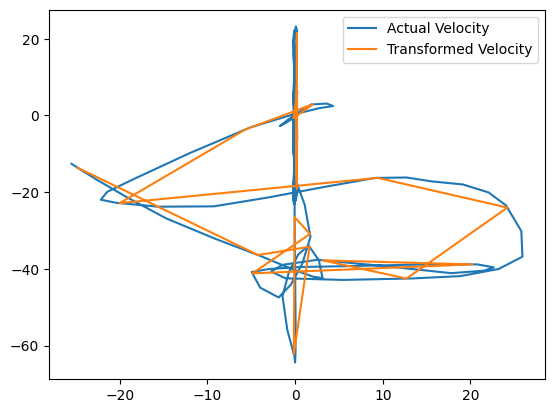

In [4]:
# for session_id, intervals in sampling_intervals.items():
# session_id = 'perich_miller_population_2018/c_20131003_center_out_reaching'
error_session_intervals = []
max_values = []
for session_id in sessions:
    if ('churchland_shenoy_neural_2012/jenkins' in session_id) and ('center_out' in session_id):
        intervals = sampling_intervals[session_id]
        for i in range(len(intervals.start)):
            start, end = intervals.start[i], intervals.end[i]
            data = train_dataset.get_recording_data(session_id).slice(start, end)
            try:
                transformed_data = transform_brainsets_regular_time_series_smoothed(data)
                actual_vel = data.cursor.vel
                actual_timestamps = data.cursor.timestamps
                transformed_vel = transformed_data['behavior_input']
                max_value = int(np.abs(transformed_vel).max())
                max_values.append(max_value)
                if actual_timestamps[0] > 0.01:
                    error_session_intervals.append((session_id, start, end))
                    print(f"INVALID: Start timestamp is {actual_timestamps[0]} for {session_id} between {start} and {end}")
            except:
                continue
        # print("no invalid transformations found in session", session_id)

import matplotlib.pyplot as plt
plt.plot(actual_vel[:, 0], actual_vel[:, 1], label='Actual Velocity')
plt.plot(transformed_vel[:, 0], transformed_vel[:, 1], label='Transformed Velocity')
plt.legend()

In [21]:
for session_id in sessions:
    if ('churchland_shenoy_neural_2012/jenkins' in session_id) and ('center_out' in session_id):
        intervals = sampling_intervals[session_id]
        for i in range(len(intervals.start)):
            start, end = intervals.start[i], intervals.end[i]
            error_session_intervals.append((session_id, start, end))
            if i > 15:
                break
        break 

In [22]:
from foundational_ssm.utils import load_model_and_state_from_checkpoint_wandb
import equinox as eqx
import jax
artifact_full_name = 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:best'
model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)
inf_model = eqx.nn.inference_mode(model)

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': True, 'window_length': 3.279}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'train

wandb:   3 of 3 files downloaded.  


/tmp/ipykernel_278692/1905161035.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  transformed = {k: jax.device_put(np.array(v)) for k, v in transformed.items()}


Text(0.5, 0.98, 'Outlier Segments for Perich Miller Task')

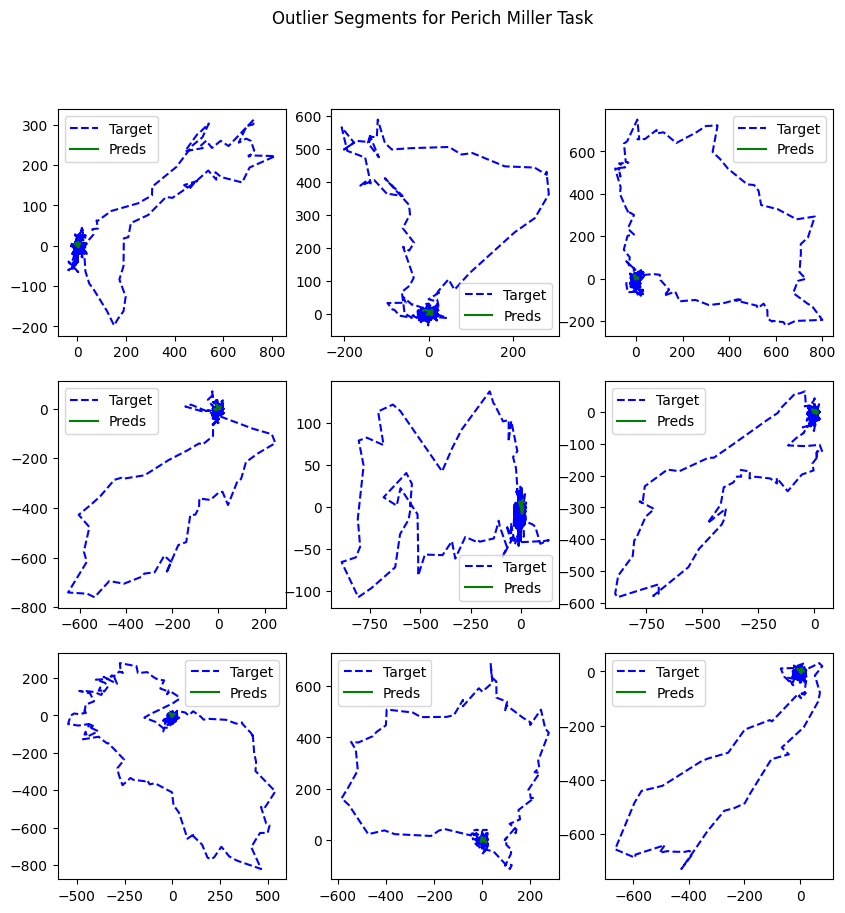

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for i, (session_id, start, end) in enumerate(error_session_intervals[:9]):
    data = train_dataset.get_recording_data(session_id).slice(start, end)
    actual_vel = data.cursor.vel
    transformed = transform_brainsets_regular_time_series_smoothed(data)
    transformed = {k: jax.device_put(np.array(v)) for k, v in transformed.items()}
    transformed_vel = transformed['behavior_input']
    transformed_spikes = transformed['neural_input']
    pred, state = inf_model(transformed_spikes, state, 0, jr.PRNGKey(0))
    # axs[i].plot(actual_vel[:, 0], actual_vel[:, 1], label='Actual Velocity', color='grey')
    axs[i].plot(transformed_vel[:, 0], transformed_vel[:, 1], label='Target', color='blue', linestyle='--')
    axs[i].plot(pred[:, 0], pred[:, 1], label='Preds', color='green')
    # axs[i].set_title(f"Session {session_id}")
    axs[i].legend()
    
plt.suptitle("Outlier Segments for Perich Miller Task")

/tmp/ipykernel_278692/3869812628.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}


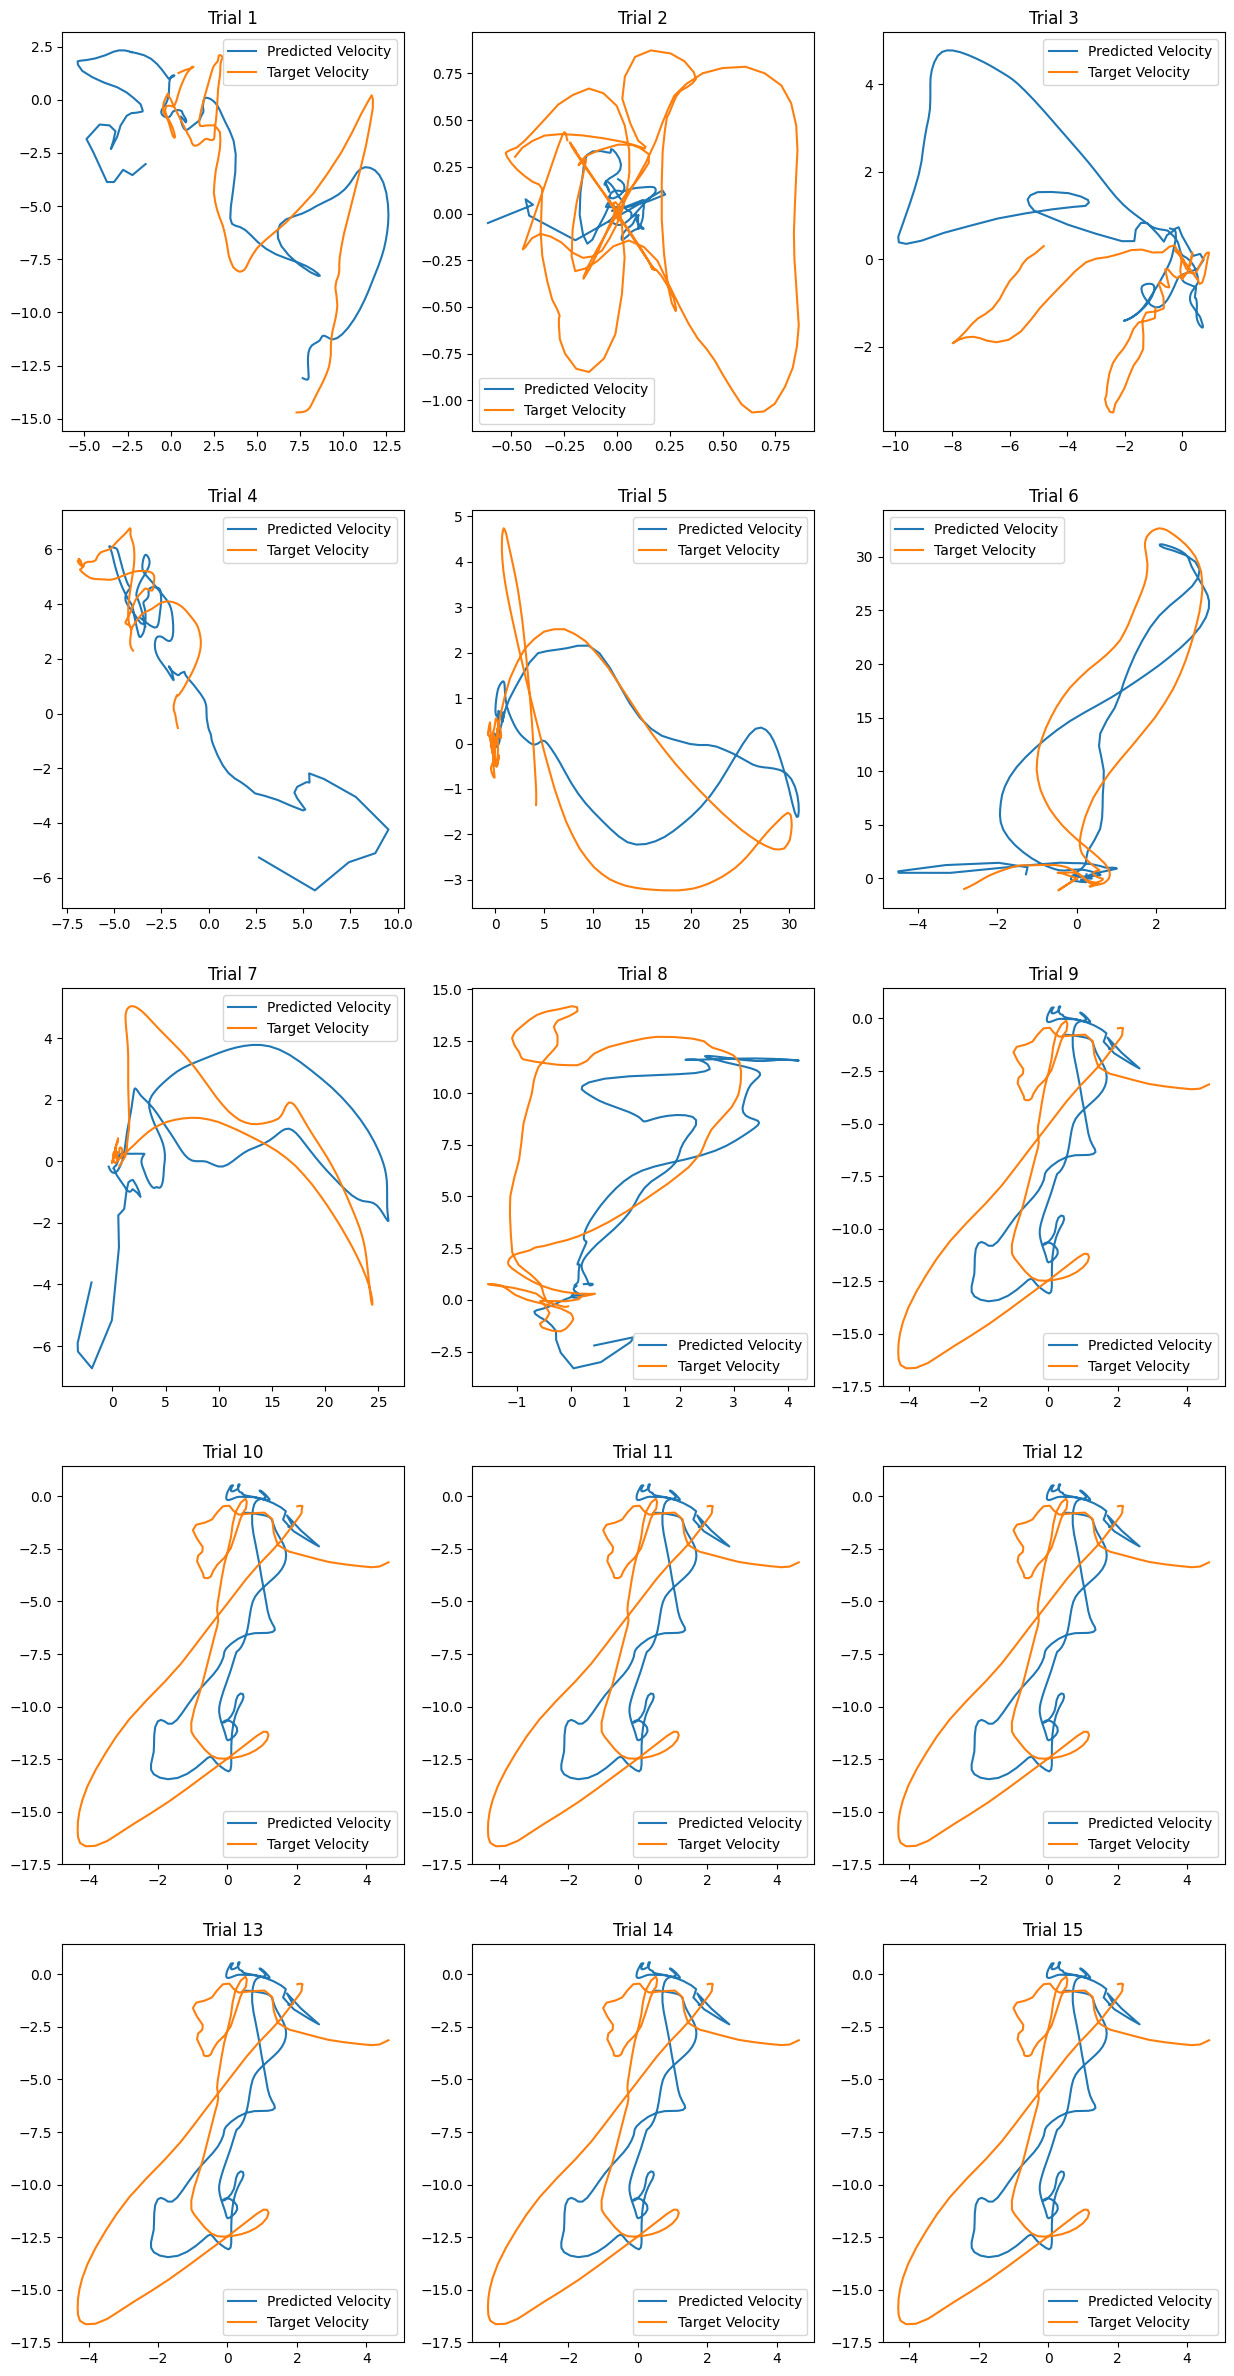

In [ ]:
import equinox as eqx
import jax
import numpy as np
inf_model = eqx.nn.inference_mode(model)
for batch in train_loader: 
    batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
    dataset_group_idxs = batch["dataset_group_idx"]
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    preds, state = jax.vmap(inf_model, axis_name="batch", in_axes=(0, None, 0, None), out_axes=(0, None))(inputs, state, dataset_group_idxs, jr.PRNGKey(0))
    break

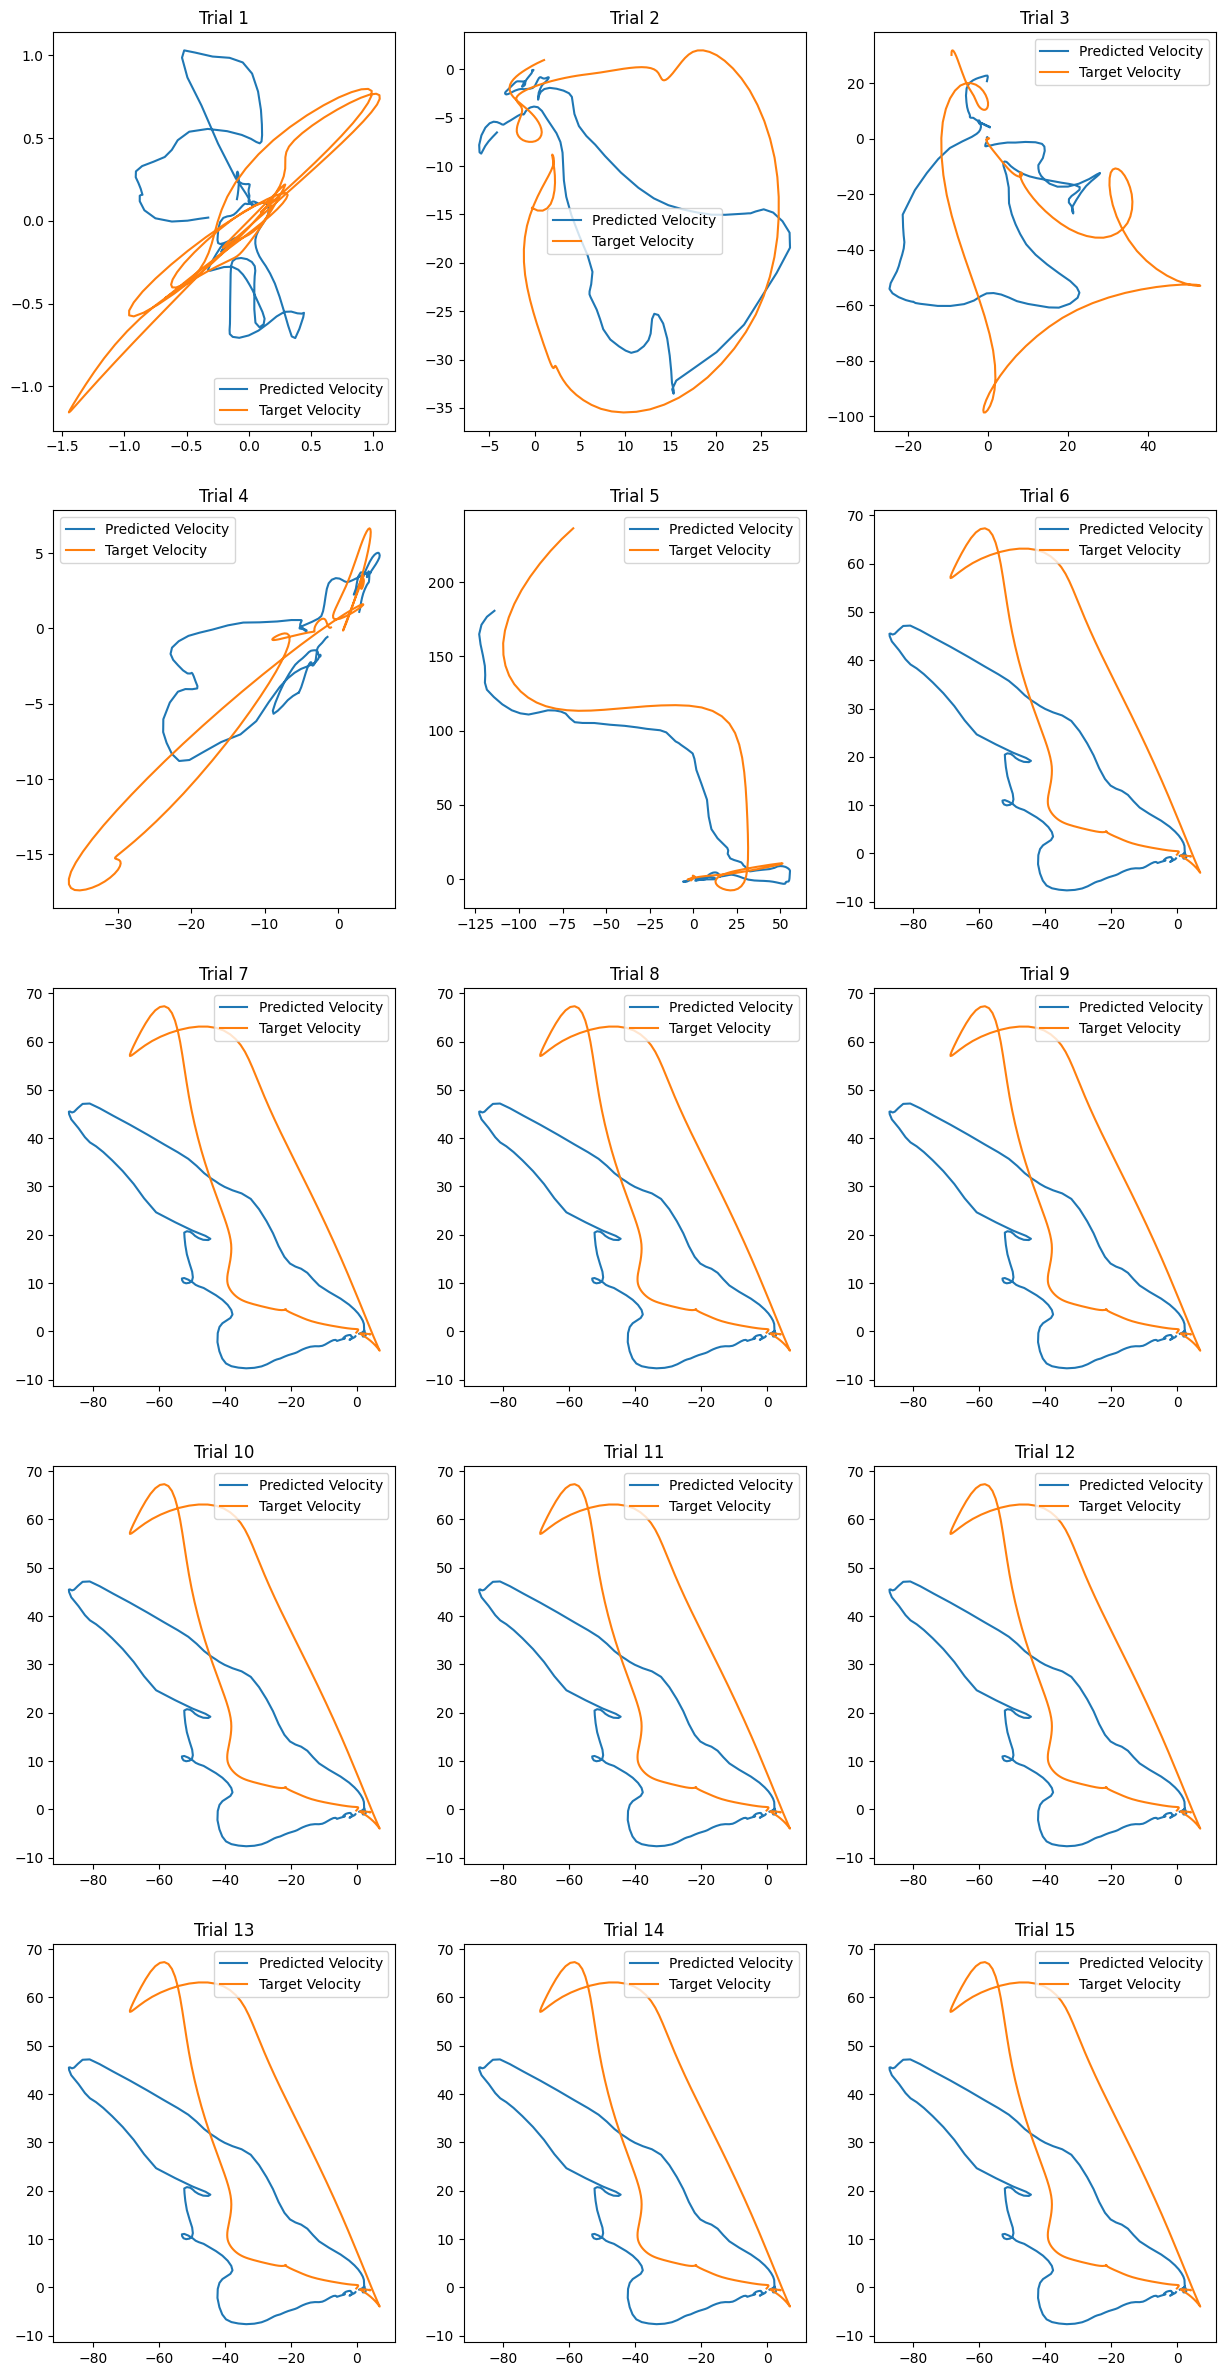

In [36]:
g = 6
c_co_targets = targets[dataset_group_idxs == g]
c_co_preds = preds[dataset_group_idxs == g] 

fig, axs = plt.subplots(5, 3, figsize=(15, 30))
axs = axs.flatten()
for i in range(15):
    pred = c_co_preds[i]
    target = c_co_targets[i]
    ax = axs[i] 
    ax.plot(pred[56:, 0], pred[56:, 1], label='Predicted Velocity')
    ax.plot(target[56:, 0], target[56:, 1], label='Target Velocity')
    ax.set_title(f"Trial {i+1}")
    ax.legend()

In [ ]:
import equinox as eqx
import jax
import numpy as np
inf_model = eqx.nn.inference_mode(model)
for batch in train_loader: 
    batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
    dataset_group_idxs = batch["dataset_group_idx"]
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    preds, state = jax.vmap(inf_model, axis_name="batch", in_axes=(0, None, 0, None), out_axes=(0, None))(inputs, state, dataset_group_idxs, jr.PRNGKey(0))
    break

Array([[-7.50762701e-01,  7.15551972e-01],
       [ 4.96246994e-01,  9.42009330e-01],
       [ 1.26909173e+00,  6.34847224e-01],
       [ 1.29479671e+00,  4.63485032e-01],
       [ 1.43883741e+00,  3.23007107e-01],
       [ 1.26269090e+00,  4.44091439e-01],
       [ 1.10274088e+00,  5.39195120e-01],
       [ 8.50049376e-01,  5.18778443e-01],
       [ 5.28473496e-01,  2.40396246e-01],
       [ 2.86024839e-01,  4.95016500e-02],
       [ 1.57339096e-01,  7.26777166e-02],
       [ 9.82696563e-02,  1.21970966e-01],
       [ 9.73211750e-02,  1.29689470e-01],
       [ 1.15203470e-01,  1.64411202e-01],
       [ 1.40704960e-01,  2.02334061e-01],
       [ 1.58815235e-01,  2.22856045e-01],
       [ 1.79030836e-01,  2.47066662e-01],
       [ 1.93202883e-01,  2.54177243e-01],
       [ 2.09601641e-01,  2.60508239e-01],
       [ 2.24844873e-01,  2.69013494e-01],
       [ 2.38748059e-01,  2.80483782e-01],
       [ 2.52385676e-01,  2.98432857e-01],
       [ 2.68432260e-01,  3.20804000e-01],
       [ 2.